In [1]:
%matplotlib inline

from statsbombpy import sb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager as fm, rcParams
import os
from mplsoccer.pitch import Pitch

from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
from mplsoccer.utils import FontManager
import seaborn as sns
from matplotlib.colors import to_rgba, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects

from PIL import Image

from urllib.request import urlopen, urlretrieve
from highlight_text import HighlightText, ax_text, fig_text
import requests
from io import BytesIO
import cmasher as cmr

In [2]:
pitchColor = "#7FB069"
figColor = "#7FB069"
linesColor = "black"
tournament = "EURO 2020"

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
parser = Sbopen()
match_files = [3847567, 3845506, 3835335, 3835323, 3835325, 3835324, 
               3835331, 3835320, 3845507, 3844387, 3844384, 3844385, 
               3844386, 3835342, 3835337, 3835338, 3835330, 3835329, 
               3835322, 3835332, 3835327, 3835326, 3835341, 3835340, 
               3835339, 3835336, 3835334, 3835328, 3835333, 3835321, 
               3835319]
df = pd.concat([parser.event(file)[0] for file in match_files])

In [5]:
goalkick = df[df["sub_type_name"]=="Goal Kick"]
goalkick = goalkick[goalkick["x"]!=10.3]
goalkick = goalkick[goalkick["outcome_name"]!="Out"]
goalkick = goalkick[goalkick["outcome_name"]!="Unknown"]
goalkick = goalkick[goalkick["outcome_name"]!="Incomplete"]
goalkick = goalkick[['team_name', 'player_name', 'minute', 'second', 'x',"y", 
                     "end_x","end_y" , "type_name", "outcome_name", "sub_type_name"]]

In [6]:
teamlist = goalkick["team_name"].unique()

In [7]:
teamlist

array(["Germany Women's", "England Women's", "Sweden Women's",
       'Northern Ireland', "Switzerland Women's", "Portugal Women's",
       "Italy Women's", "France Women's", "Netherlands Women's",
       "Norway Women's", "Spain Women's", "Austria Women's",
       "Belgium Women's", "Iceland Women's", "Denmark Women's",
       'WNT Finland'], dtype=object)

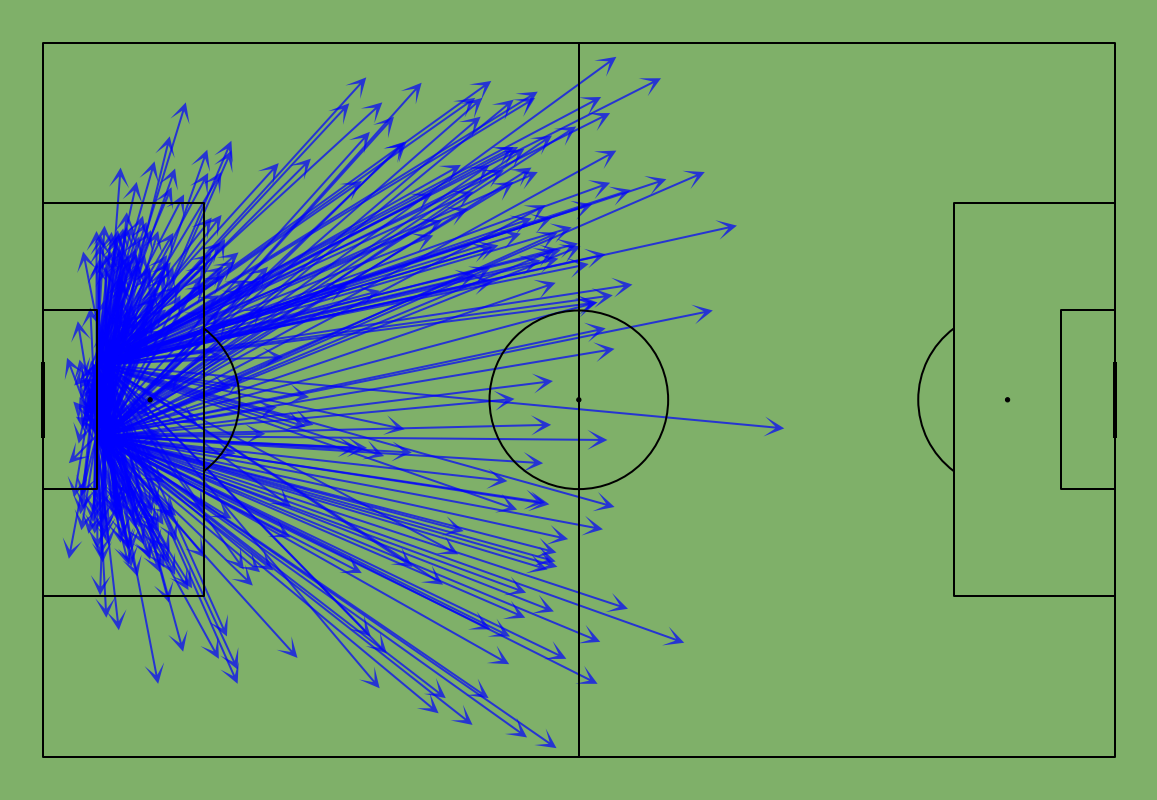

In [8]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, line_color= linesColor, pitch_color= pitchColor)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor(pitchColor)

pitch.arrows(goalkick.x, goalkick.y,
             goalkick.end_x, goalkick.end_y, width=2,
             headwidth=10, headlength=10, color= "blue", ax=ax, alpha = .70)

In [9]:
teamlist

array(["Germany Women's", "England Women's", "Sweden Women's",
       'Northern Ireland', "Switzerland Women's", "Portugal Women's",
       "Italy Women's", "France Women's", "Netherlands Women's",
       "Norway Women's", "Spain Women's", "Austria Women's",
       "Belgium Women's", "Iceland Women's", "Denmark Women's",
       'WNT Finland'], dtype=object)

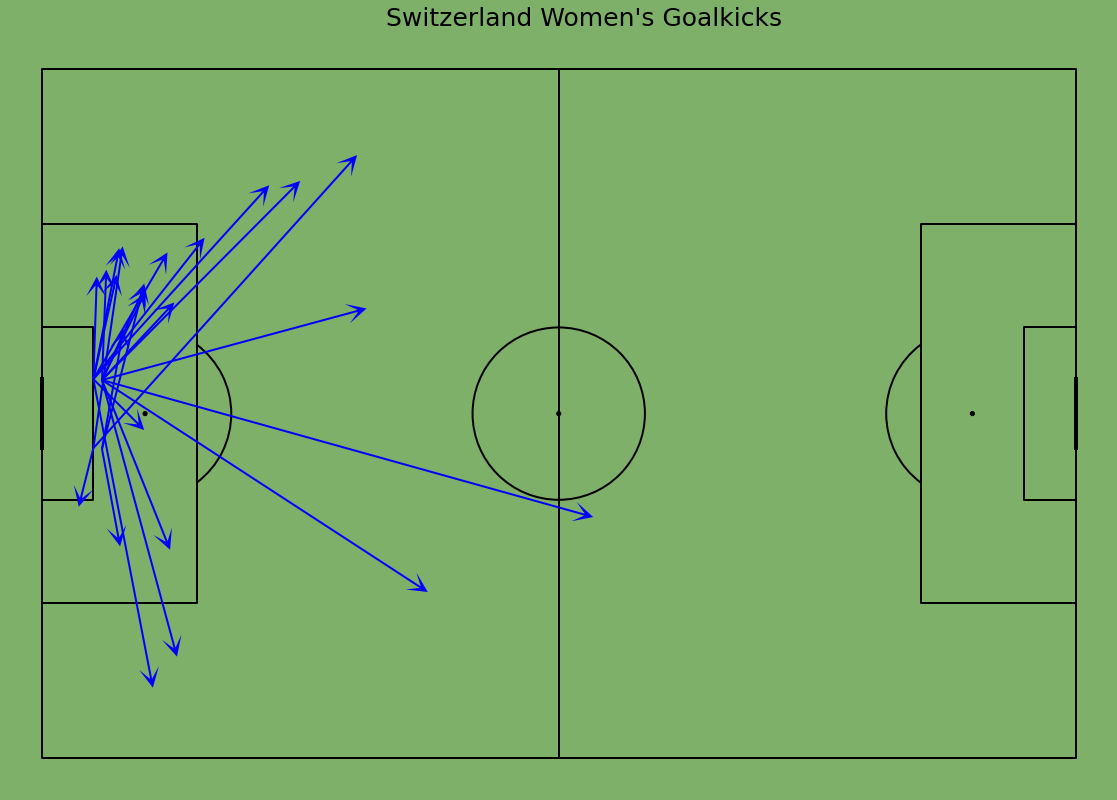

In [10]:
def Goalkick(team, color = '#444444', save=False):

    tempdf = goalkick[goalkick['team_name'] == team]
    
    pitch = Pitch(pitch_type='statsbomb', line_zorder=1, line_color= linesColor, pitch_color= pitchColor)
    fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
    fig.set_facecolor(pitchColor)

    pitch.arrows(tempdf['x'], tempdf['y'],
    tempdf['end_x'], tempdf['end_y'], ax=ax, color="blue", width=2,
             headwidth=10, headlength=10)

    ax.text(40, -5, f"{team} Goalkicks", fontsize=25)

    if save == True:
        plt.savefig(f"{team} Viz/goalkick.png")
        plt.close(fig)
    else:    
        plt.show()

Goalkick("Switzerland Women's")

ValueError: ('Lengths must match to compare', (375,), (16,))

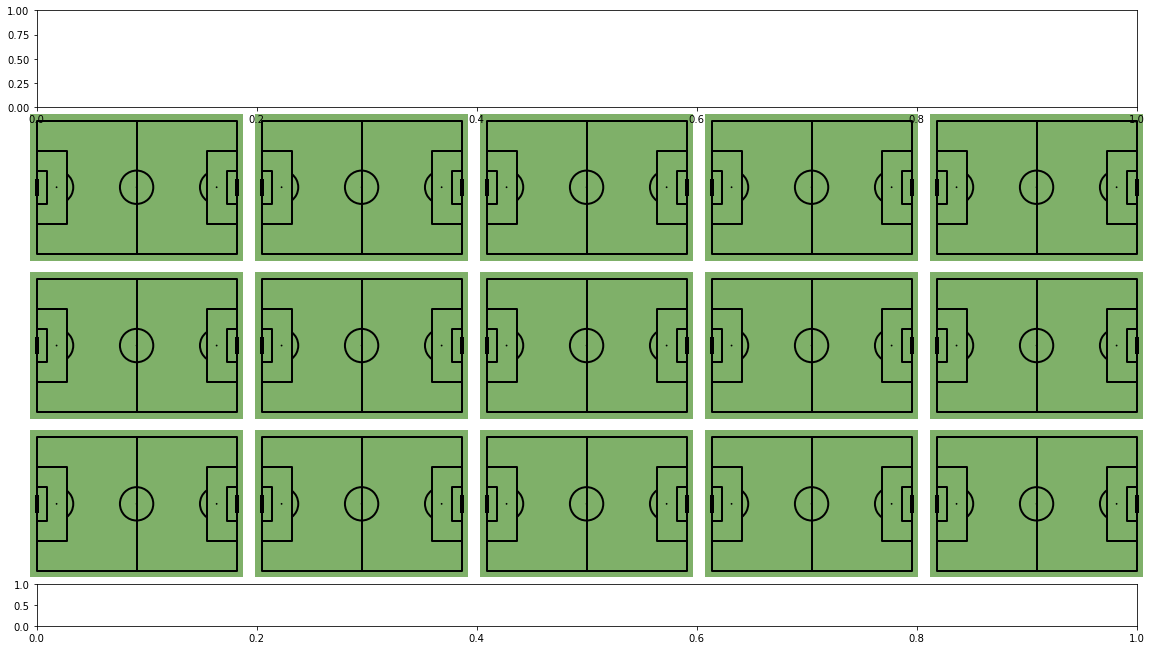

In [65]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=1, line_color= linesColor, pitch_color= pitchColor)
fig, axs = pitch.grid(ncols=5, nrows=3)

for team in goalkick["team_name"].unique(), ax in enumerate(axs['pitch'].flat):

    tempdf = goalkick[goalkick["team_name"]==team]

    pitch.arrows(tempdf['x'], tempdf['y'],
    tempdf['end_x'], tempdf['end_y'], ax=ax, color="blue", width=2,
             headwidth=10, headlength=10)

In [11]:
path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()]

In [12]:
pitchCmap = LinearSegmentedColormap.from_list("pitch heatmap", ["#7FB069","#D36135"], N=100)

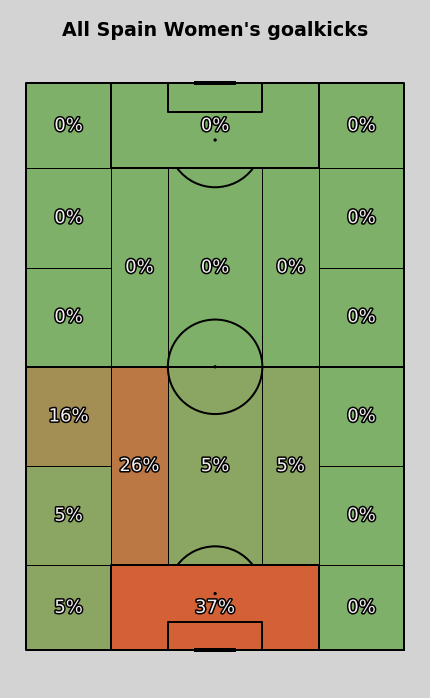

In [15]:
def Goalkick(team, color = '#444444', save=False):

    tempdf = goalkick[goalkick['team_name'] == team]
    
    pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color="lightgrey", line_color=linesColor)
    fig, axs = pitch.grid(figheight=10, endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      axis=False,
                      grid_height=0.84)
    fig.set_facecolor("lightgrey")

    bin_statistic = pitch.bin_statistic_positional(tempdf.end_x, tempdf.end_y, statistic='count',
                                               positional='full', normalize=True)
    pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap=pitchCmap, edgecolors=linesColor)
    labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

    axs["title"].text (0.5, 0.6, (f"All {team} goalkicks"), color="black", 
                   va="center", ha="center", fontsize=19, fontweight="bold")
    if save == True:
        plt.savefig(f"{team} Viz/goalkick.png")
        plt.close(fig)
    else:    
        plt.show()

Goalkick("Spain Women's")